**Authors:** Alexis Bouley and Matias Etcheverry

## Protein Cellular Component ontology prediction

The goal of this notebook is to predict classes on proteins graph.

### Load data

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import optim
from tqdm import tqdm, trange
from tqdm.auto import tqdm
from transformers import BertModel, BertTokenizer

# path_to_dataset = Path("/kaggle/input/challenge-altegrad-alb/")
path_to_dataset = Path("dataset/")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


2023-01-19 19:36:22.114633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 19:36:25.023199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2023-01-19 19:36:25.023875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2023-01-19 19:36:25.023885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def create_smooth_adjency_from_edges(edges, edge_attr):
    """
    Function which creates a smooth adjacency matrix, wrt `edge_attr`
    """
    A = sp.csr_matrix(
        (
            sigmoid(
                (-(edge_attr[:, 0] - edge_attr[:, 0].mean()) / edge_attr[:, 0].std())
            ),
            (edges[:, 0], edges[:, 1]),
        ),
        # (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(graph_indicator.size, graph_indicator.size),
    )
    return A


def normalize_adjacency(A):
    """
    Function that normalizes an adjacency matrix
    """

    n = A.shape[0]
    A = A + sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D = sp.diags(inv_degs)
    A_normalized = D @ A

    return A_normalized


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Function that converts a Scipy sparse matrix to a sparse Torch tensor
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def save_predictions(predictions, fname):
    """
    Saves `predictions` at `fname`
    """
    submission = pd.DataFrame(
        predictions,
        columns=[f"class{i}" for i in range(18)],
        index=graph_labels[graph_labels["class"].isna()]["name"],
    )
    submission.to_csv(fname)


In [3]:
# edges = np.loadtxt(
#     path_to_dataset / "edgelist.txt",
#     dtype=np.int64,
#     delimiter=",",
# )

edges = np.load(
    path_to_dataset / "edges.npy",
)

graph_indicator = np.loadtxt(path_to_dataset / "graph_indicator.txt", dtype=np.int64)
_, graph_size = np.unique(graph_indicator, return_counts=True)

sequences = open(path_to_dataset / "sequences.txt", "r").readlines()
sequences = np.array([seq.replace("\n", "") for seq in sequences])

x = np.loadtxt(path_to_dataset / "node_attributes.txt", delimiter=",")
edge_attr = np.loadtxt(path_to_dataset / "edge_attributes.txt", delimiter=",")

graph_labels = pd.read_csv(
    path_to_dataset / "graph_labels.txt", names=["name", "class"]
)


In [4]:
def compute_global_graph_features(adj, node_features):
    """
    Computes global graph features like nb of nodes, from an adjacency matrix
    """
    graph = nx.from_numpy_matrix(adj)
    connected_components = list(nx.connected_components(graph))
    giant_connected_component = nx.subgraph(graph, connected_components[0])
    nb_connected_components = len(connected_components)
    degree_sequence = [graph.degree(node) for node in graph.nodes()]
    graph_features = [
        len(graph.nodes),
        len(graph.edges),
        nb_connected_components,
        len(giant_connected_component.nodes),
        len(giant_connected_component.edges),
        np.mean(degree_sequence),
        np.max(degree_sequence),
        np.min(degree_sequence),
        np.max(node_features[:, 0]) - np.min(node_features[:, 0]),
        np.max(node_features[:, 1]) - np.min(node_features[:, 1]),
        np.max(node_features[:, 2]) - np.min(node_features[:, 2]),
    ]
    return graph_features


def load_data():
    """
    Function that loads graphs
    """

    ADJ = [
        create_smooth_adjency_from_edges(edges, edge_attr[:, 0])
    ]
    ADJ.extend(
        [
            sp.csr_matrix(
                ((edge_attr[:, i]), (edges[:, 0], edges[:, 1])),
                shape=(graph_indicator.size, graph_indicator.size),
            )
            for i in [2, 4]
        ]
    )
    adj = [[], [], []]
    binary_adj = sp.csr_matrix(
        (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(graph_indicator.size, graph_indicator.size),
    )
    binary_adj += binary_adj.T
    features = []
    graph_features = []
    idx_n = 0

    for i in trange(graph_size.size, desc="Building adj matrices"):
        for _adj, _ADJ in zip(adj, ADJ):
            _adj.append(
                _ADJ[idx_n : idx_n + graph_size[i], idx_n : idx_n + graph_size[i]]
            )
        features.append(x[idx_n : idx_n + graph_size[i], :])
        graph_features.append(
            compute_global_graph_features(
                binary_adj[
                    idx_n : idx_n + graph_size[i], idx_n : idx_n + graph_size[i]
                ].toarray(),
                x[idx_n : idx_n + graph_size[i], :],
            )
        )
        idx_n += graph_size[i]

    adj = [[normalize_adjacency(a + a.T) for a in _adj] for _adj in adj]

    return adj, features, sequences, graph_features


adj, features, sequences, graph_features = load_data()


Building adj matrices: 100%|██████████| 6111/6111 [01:42<00:00, 59.70it/s] 


In [5]:
train_idx = np.array(graph_labels[(~graph_labels["class"].isna())].index)
test_idx = np.array(graph_labels[graph_labels["class"].isna()].index)


def create_dataset(indices):
    y_split = np.array(graph_labels.iloc[indices]["class"])
    adj_split = [[], [], []]
    features_split = []
    sequences_split = []
    graph_features_split = []
    for idx in tqdm(indices):
        for index, _adj in enumerate(adj_split):
            _adj.append(adj[index][idx])
        features_split.append(
            (features[idx] - features[idx].mean(axis=0))
            / (features[idx].std(axis=0) + 0.1)
        )
        sequences_split.append(" ".join(list(sequences[idx])))
        graph_features_split.append(graph_features[idx])
    adj_split = [np.array(_adj, dtype="object") for _adj in adj_split]
    sequences_split = np.array(sequences_split, dtype="object")
    return adj_split, features_split, sequences_split, graph_features_split, y_split


(
    adj_train,
    features_train,
    sequences_train,
    graph_features_train,
    y_train,
) = create_dataset(train_idx)
adj_test, features_test, sequences_test, graph_features_test, y_test = create_dataset(
    test_idx
)


N_train = int(0.9 * len(sequences_train))
N_test = len(sequences_train) - N_train

sequences_val = sequences_train[N_train:]
sequences_train = sequences_train[:N_train]
y_val = y_train[N_train:]
y_train = y_train[:N_train]

adj_val = [_adj[N_train:] for _adj in adj_train]
adj_train = [_adj[:N_train] for _adj in adj_train]
features_val = features_train[N_train:]
features_train = features_train[:N_train]
graph_features_val = graph_features_train[N_train:]
graph_features_train = graph_features_train[:N_train]


  0%|          | 0/4888 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

### Visualize data

In [6]:
ALPHABET = set()
counter = 0
while len(ALPHABET) <= 20:
    ALPHABET = ALPHABET.union(set(sequences_train[counter].replace(" ", "")))
    counter += 1
ALPHABET = sorted(list(ALPHABET))
print(f"There is {len(ALPHABET)} different acids: {ALPHABET}")


There is 21 different acids: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']


In [31]:
graphs = {_y: {} for _y in range(18)}
lengths = {_y: {} for _y in range(18)}
sequence = {_y: {} for _y in range(18)}
for _adj, _seq, _y in tqdm(
    zip(adj_train[2], sequences_train, y_train), total=len(y_train)
):
    if lengths[_y].get("big", 0) < len(_seq):
        lengths[_y]["big"] = len(_seq)
        graphs[_y]["big"] = nx.from_numpy_array(_adj.toarray() > 0)
        sequence[_y]["big"] = _seq.replace(" ", "")
    if lengths[_y].get("small", np.inf) > len(_seq):
        lengths[_y]["small"] = len(_seq)
        graphs[_y]["small"] = nx.from_numpy_array(_adj.toarray() > 0)
        sequence[_y]["small"] = _seq.replace(" ", "")

fig, axs = plt.subplots(6, 6, figsize=(16, 14))

cmap = [
    mcolors.rgb2hex(mpl.colormaps["gist_rainbow"](i))
    for i in np.linspace(0, 256, 21, dtype="int")
]

for _y in trange(18):
    nrow = _y // 6
    ncol = _y % 6

    nx.draw(
        graphs[_y]["small"],
        ax=axs[2 * nrow, ncol],
        node_size=12,
        width=0.5,
        node_color=[cmap[ALPHABET.index(acid)] for acid in sequence[_y]["small"]],
        edge_color="#2e2e2e",
    )

    nx.draw(
        graphs[_y]["big"],
        ax=axs[2 * nrow + 1, ncol],
        node_size=8,
        width=0.2,
        node_color=[cmap[ALPHABET.index(acid)] for acid in sequence[_y]["big"]],
        edge_color="#2e2e2e",
    )
    axs[2 * nrow + 1, ncol].set_title(
        f"Smallest (top) and longest \n(bottom) protein for class {_y}", y=-0.3
    )
plt.tight_layout()
plt.savefig("proteins.png", dpi=400)


  0%|          | 0/4399 [00:00<?, ?it/s]

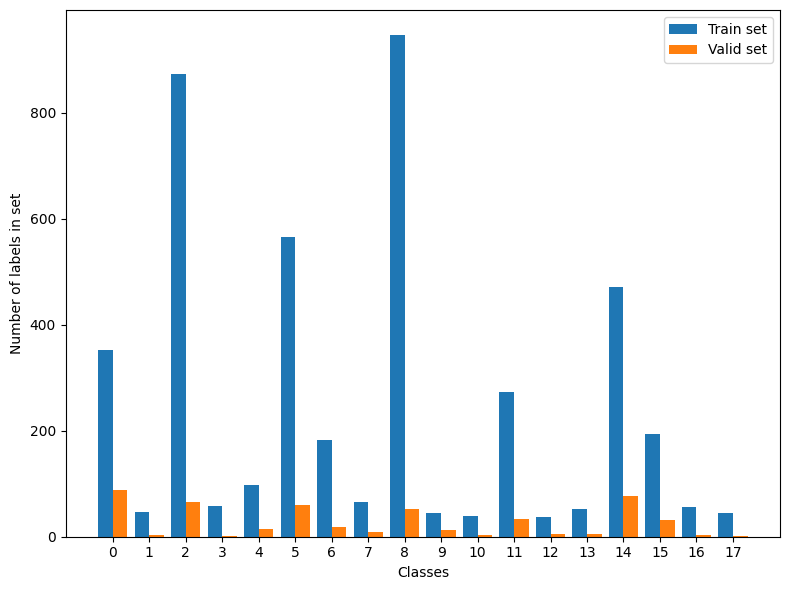

In [7]:
fig, axs = plt.subplots(1, 1, squeeze=False, figsize=(8, 6))

bin = np.arange(1, 19)  # len + 1
axs[0, 0].hist(
    [y_train, y_val], bins=np.arange(0, 19), label=["Train set", "Valid set"]
)
axs[0, 0].legend()
axs[0, 0].set_xticks(bin - 0.5, bin - 1)
axs[0, 0].set_ylabel("Number of labels in set")
axs[0, 0].set_xlabel("Classes")
plt.tight_layout()
plt.savefig("train_valid_split.png")


### TF-IDF Embedding

The first algorithm consists in:
1. embed the string sequences only with a TF-IDF. Each sequence is embedded in a vector of length 8459
2. add 11 global graph features the embedding. Those features are scaled in [0, 1]
3. apply logistic regression on the union of the global graph features and the embedded sequences.

In [12]:
# Map sequences to
vec = TfidfVectorizer(analyzer="char", ngram_range=(1, 3))
sequences_emb_train = vec.fit_transform(
    [seq.replace(" ", "") for seq in sequences_train]
).toarray()
sequences_emb_val = vec.transform(
    [seq.replace(" ", "") for seq in sequences_val]
).toarray()
sequences_emb_test = vec.transform(
    [seq.replace(" ", "") for seq in sequences_test]
).toarray()

scaler = MinMaxScaler()
scaler.fit(graph_features_train)

emb_train = np.concatenate(
    (sequences_emb_train, scaler.transform(graph_features_train)), axis=1
)
emb_val = np.concatenate(
    (sequences_emb_val, scaler.transform(graph_features_val)), axis=1
)
emb_test = np.concatenate(
    (sequences_emb_test, scaler.transform(graph_features_test)), axis=1
)


In [13]:
clf = LogisticRegression(
    solver="liblinear", penalty="l2", C=30, class_weight="balanced"
)
clf.fit(emb_train, y_train)
y_pred_proba_seq_train = clf.predict_proba(emb_train)
y_pred_proba_seq_val = clf.predict_proba(emb_val)
y_pred_proba_seq_test = clf.predict_proba(emb_test)

y_pred_seq_train = np.argmax(y_pred_proba_seq_train, axis=1)
y_pred_seq_val = np.argmax(y_pred_proba_seq_val, axis=1)
print(
    "Train Accuracy: {:.2f}% | Train LogLoss: {:.4f}".format(
        np.mean(y_train == y_pred_seq_train) * 100,
        log_loss(y_train, y_pred_proba_seq_train),
    )
)
print(
    "Valid Accuracy: {:.2f}% | Valid LogLoss: {:.4f}".format(
        np.mean(y_val == y_pred_seq_val) * 100, log_loss(y_val, y_pred_proba_seq_val)
    )
)


Train Accuracy: 99.45% | Train LogLoss: 0.2573
Valid Accuracy: 59.51% | Valid LogLoss: 1.3343


### GCN

The second algorithm consists in a GCN:
1. each node of a sequence is embedded to a vector of length 1084. This embedding is made with a pretrained Bert model, applied on the string sequence only. Due to memory limitations, we only embed the first 200 nodes of a sequence.
2. We define a GNN made of a single message passing layer. This message passing layer uses 3 adjacency matrix, in parallel:
    * distance based adjacency
    * peptide bond adjacency 
    * hydrogen bond adjacency

#### Bert Embedding

We first embed the string sequences.


In [19]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedder = BertModel.from_pretrained("Rostlab/prot_bert_bfd").to(device)
_ = embedder.eval()


def embed_sequences(sequences, max_nodes=200, batch_size=32):
    embed_features = []
    for i in trange(0, len(sequences), batch_size):
        sequences_batch = []
        for j in range(i, min(len(sequences), i + batch_size)):
            sequences_batch.append(sequences[j][: 2 * max_nodes - 2])

        ids = tokenizer.batch_encode_plus(
            sequences_batch,
            add_special_tokens=True,
            padding="max_length",
            max_length=max_nodes + 1,
        )
        input_ids = torch.tensor(ids["input_ids"]).to(device)
        attention_mask = torch.tensor(ids["attention_mask"]).to(device)

        with torch.no_grad():
            embedding = embedder(input_ids=input_ids, attention_mask=attention_mask)[0]

        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][1 : seq_len - 1]
            embed_features.append(seq_emd)
    return embed_features


max_nodes = 200
embedded_sequences_train = embed_sequences(sequences_train, max_nodes=max_nodes)
embedded_sequences_val = embed_sequences(sequences_val, max_nodes=max_nodes)
embedded_sequences_test = embed_sequences(sequences_test, max_nodes=max_nodes)


100%|██████████| 39/39 [00:31<00:00,  1.24it/s]


#### Checkpoint Callback

We then define a class used to save the best model, during the training.

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """

    def __init__(self, best_valid_loss=float("inf")):
        self.best_valid_loss = best_valid_loss
        self.path_to_model = None

    def __call__(
        self,
        current_valid_loss,
        current_valid_accuracy,
        epoch,
        model,
        optimizer,
        criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            path_to_model = "/kaggle/working/{}-val_l-{:.2f}-val_acc-{:.2f}.pth".format(
                epoch, current_valid_loss, current_valid_accuracy
            )
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": criterion,
                },
                path_to_model,
            )
            if self.path_to_model is not None and Path(self.path_to_model).exists():
                Path(self.path_to_model).unlink()
            self.path_to_model = path_to_model


#### Model definition

We then define the GNN model.

In [20]:
class GNN_ter(nn.Module):
    """
    Simple message passing model that consists of 2 message passing layers
    and the sum aggregation function
    """

    def __init__(self, input_dim, hidden_dims, dropout, n_class):
        super(GNN_ter, self).__init__()

        hidden_dim_1 = hidden_dims[0]
        hidden_dim_2 = hidden_dims[1]
        hidden_dim_4 = hidden_dims[2]
        hidden_dim = hidden_dim_1 + hidden_dim_2 + hidden_dim_4

        self.fc1_1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc1_2 = nn.Linear(input_dim, hidden_dim_2)
        self.fc1_4 = nn.Linear(input_dim, hidden_dim_4)

        self.fc2 = nn.Linear(hidden_dim, n_class)

        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, adj, idx):

        adj_1 = adj[0]
        adj_2 = adj[1]
        adj_4 = adj[2]

        # first message passing layer

        x_1 = self.fc1_1(x_in)
        x_2 = self.fc1_2(x_in)
        x_4 = self.fc1_4(x_in)

        x = self.relu(torch.mm(adj_1, x_1))
        x_2 = self.relu(torch.mm(adj_2, x_2))
        x_4 = self.relu(torch.mm(adj_4, x_4))

        x = torch.cat([x_1, x_2, x_4], dim=1)
        x = self.dropout(x)

        # sum aggregator
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx) + 1, x.size(1)).to(x_in.device)
        out = out.scatter_add_(0, idx, x)

        # batch normalization layer
        out = self.bn(out)

        # mlp to produce output
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)


# Hyperparameters
n_hidden_1 = 32
n_hidden_2 = 32
n_hidden_4 = 32
n_embedding_features = 256
dropout = 0.5
learning_rate = 0.001
n_class = 18
weight_decay = 0.01

# Initializes model and optimizer
model = GNN_ter(
    n_embedding_features, [n_hidden_1, n_hidden_2, n_hidden_4], dropout, n_class
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()
save_best_model = SaveBestModel()


#### Training

We define an `iterate` function which produces outputs on a given dataset. 
We then train and evaluate our model thanks to this function.

In [ ]:
# Hyperparameters
epochs = 50
batch_size = 64


def iterate(
    model,
    adj,
    embed_sequences,
    y=None,
    return_proba=False,
    mode="val",
):
    """
    Iterate the model on the dataset. Depending on the `mode`, the necessary callbacks are called.
    """
    probas = []
    total_loss = 0
    correct = 0
    count = 0
    if y is None:
        y = [0 for _ in features]

    if mode == "train":
        model.train()
    else:
        model.eval()

    pbar = trange(0, len(embed_sequences), batch_size, desc=mode)
    for i in pbar:
        # create batch tensors
        adj_batch = [[], [], []]
        embed_sequences_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(len(embed_sequences), i + batch_size)):
            nb_nodes = min(max_nodes, len(embed_sequences[j]))
            for index, _adj in enumerate(adj):
                adj_batch[index].append(_adj[j][:nb_nodes, :nb_nodes])
            embed_sequences_batch.append(embed_sequences[j][:, :n_embedding_features])
            idx_batch.extend([j - i] * nb_nodes)
            y_batch.append(int(y[j]))
        adj_batch = [
            sparse_mx_to_torch_sparse_tensor(sp.block_diag(_adj_batch)).to(device)
            for _adj_batch in adj_batch
        ]
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)
        embed_sequences_batch = torch.cat(embed_sequences_batch, axis=0)

        if mode == "train":
            optimizer.zero_grad()

        output = model(embed_sequences_batch, adj_batch, idx_batch)

        if return_proba:
            probas.append(output)

        # loss and accuracy
        loss = loss_function(output, y_batch)
        total_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double()).item()

        if mode == "train":
            loss.backward()
            optimizer.step()

        # Update progress bar metrics
        pbar.set_postfix(
            {f"{mode} Loss": total_loss / count, f"{mode} Acc": correct / count}
        )

    total_loss /= count
    total_accuracy = correct / count

    if return_proba:
        probas = torch.cat(probas, dim=0)
        probas = torch.exp(probas)
        probas = probas.detach().cpu().numpy()
        return total_loss, total_accuracy, probas
    else:
        return total_loss, total_accuracy


In [32]:
# Train model
train_metrics = {"Loss": [], "Accuracy": []}
val_metrics = {"Loss": [], "Accuracy": []}
for epoch in range(epochs):
    loss, accuracy = iterate(
        model, adj_train, embedded_sequences_train, y_train, mode="train"
    )
    train_metrics["Loss"].append(loss)
    train_metrics["Accuracy"].append(accuracy)
    val_loss, val_accuracy = iterate(
        model, adj_val, embedded_sequences_val, y_val, mode="valid"
    )
    val_metrics["Loss"].append(val_loss)
    val_metrics["Accuracy"].append(val_accuracy)
    save_best_model(val_loss, val_accuracy, epoch, model, optimizer, loss)
    if val_loss <= 1.16:
        break


valid: 100%|██████████| 8/8 [00:00<00:00, 21.37it/s, valid Loss=1.15, valid Acc=0.667]


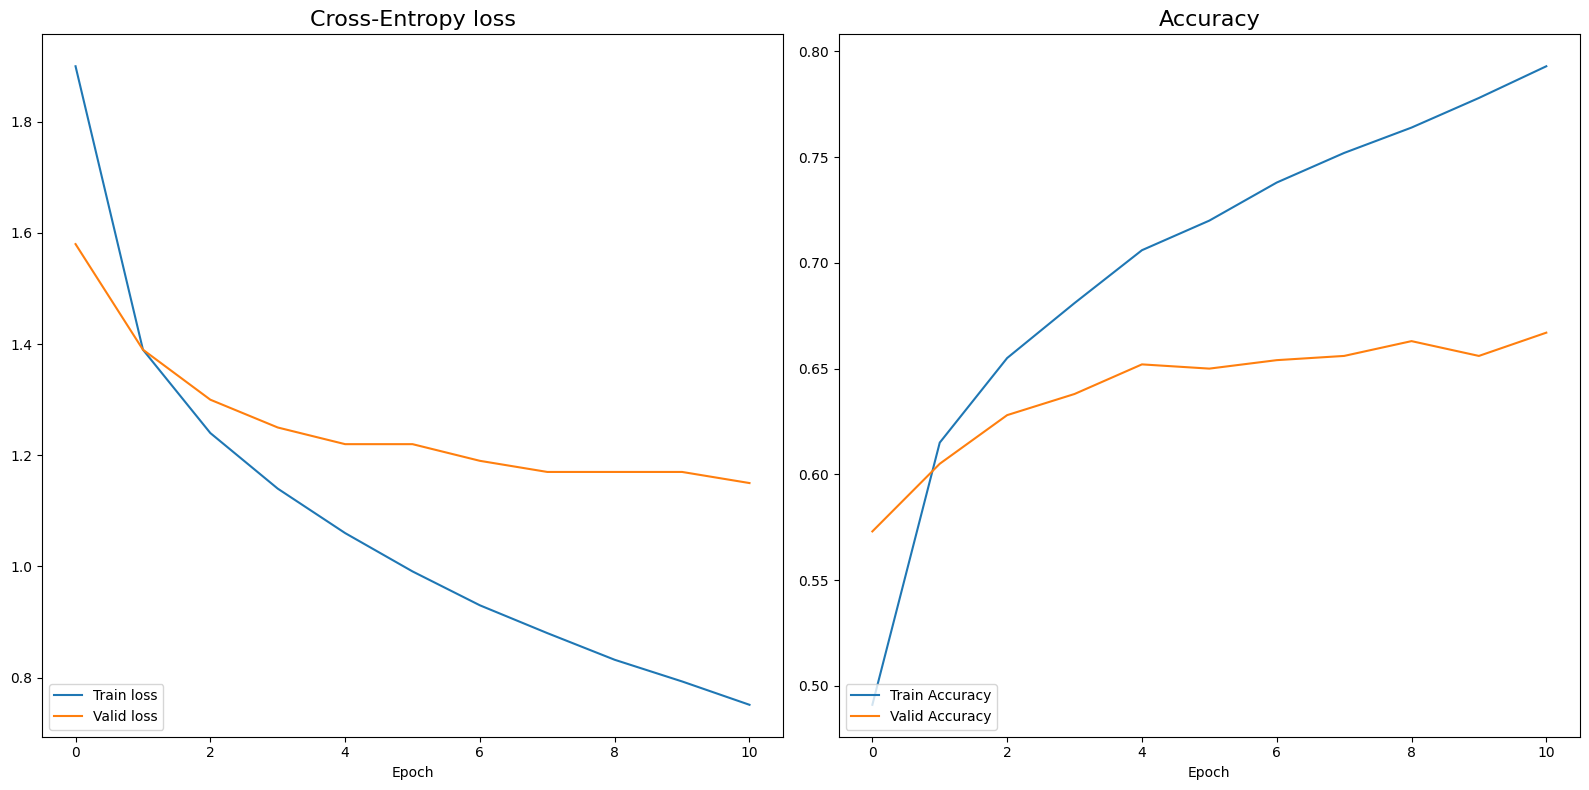

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for name, metrics in {"Train": train_metrics, "Valid": val_metrics}.items():
    axs[0].plot(metrics["Loss"], label=f"{name} loss")
    axs[1].plot(metrics["Accuracy"], label=f"{name} Accuracy")
axs[0].set_title("Cross-Entropy loss", fontsize=16)
axs[0].set_xlabel("Epoch")
axs[0].legend(loc="lower left")

axs[1].set_title("Accuracy", fontsize=16)
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower left")
plt.tight_layout()
plt.savefig("train_curves.png")


In [34]:
train_loss, train_accuracy, y_pred_proba_struct_train = iterate(
    model, adj_train, embedded_sequences_train, y_train, return_proba=True, mode="valid"
)
val_loss, val_accuracy, y_pred_proba_struct_val = iterate(
    model, adj_val, embedded_sequences_val, y_val, return_proba=True, mode="valid"
)
test_loss, test_accuracy, y_pred_proba_struct_test = iterate(
    model, adj_test, embedded_sequences_test, None, return_proba=True, mode="valid"
)

y_pred_struct_train = np.argmax(y_pred_proba_struct_train, axis=1)
y_pred_struct_val = np.argmax(y_pred_proba_struct_val, axis=1)
print(
    "Train Accuracy: {:.2f}% | Train LogLoss: {:.4f}".format(
        np.mean(y_train == y_pred_struct_train) * 100,
        log_loss(y_train, y_pred_proba_struct_train),
    )
)
print(
    "Valid Accuracy: {:.2f}% | Valid LogLoss: {:.4f}".format(
        np.mean(y_val == y_pred_struct_val) * 100,
        log_loss(y_val, y_pred_proba_struct_val),
    )
)


valid: 100%|██████████| 20/20 [00:00<00:00, 21.60it/s, valid Loss=4.97, valid Acc=0.107] 

Train Accuracy: 82.56% | Train LogLoss: 0.7135
Valid Accuracy: 66.67% | Valid LogLoss: 1.1476


### Best of the 2 approaches

We then run a linear combination on the 2 models. This combination is ran on the validation dataset.

In [35]:
y_pred_log_proba_struct_train = np.log(y_pred_proba_struct_train)
y_pred_log_proba_seq_train = np.log(y_pred_proba_seq_train)
y_pred_log_proba_struct_val = np.log(y_pred_proba_struct_val)
y_pred_log_proba_seq_val = np.log(y_pred_proba_seq_val)
y_pred_log_proba_struct_test = np.log(y_pred_proba_struct_test)
y_pred_log_proba_seq_test = np.log(y_pred_proba_seq_test)


In [73]:
alphas = np.linspace(0, 1, 100)
# combination of the 2 models
log_losses = [
    log_loss(
        y_val, alpha * y_pred_proba_struct_val + (1 - alpha) * y_pred_proba_seq_val
    )
    for alpha in alphas
]
min_alpha = np.argmin(log_losses)

# final predictions
y_pred_proba_train = (
    min_alpha * y_pred_proba_struct_train + (1 - min_alpha) * y_pred_proba_seq_train
)
y_pred_proba_val = (
    min_alpha * y_pred_proba_struct_val + (1 - min_alpha) * y_pred_proba_seq_val
)
y_pred_proba_test = (
    min_alpha * y_pred_proba_struct_test + (1 - min_alpha) * y_pred_proba_seq_test
)
y_pred_train = np.argmax(y_pred_proba_train, axis=1)
y_pred_val = np.argmax(y_pred_proba_val, axis=1)

save_predictions(y_pred_proba_test, "/kaggle/working/predictions_embed_bagged.csv")


Valid Accuracy: 70.35% | Valid LogLoss: 1.0705


In [14]:
# Uncomment to load saved predictions

path_to_predictions = Path("predictions/")
y_pred_proba_train = np.load(path_to_predictions / "y_pred_proba_train.npy")
y_pred_proba_val = np.load(path_to_predictions / "y_pred_proba_val.npy")
y_pred_proba_test = np.load(path_to_predictions / "y_pred_proba_test.npy")
y_pred_train = np.argmax(y_pred_proba_train, axis=1)
y_pred_val = np.argmax(y_pred_proba_val, axis=1)


In [15]:
print(
    "Train Accuracy: {:.2f}% | Train LogLoss: {:.4f}".format(
        np.mean(y_train == y_pred_train) * 100, log_loss(y_train, y_pred_proba_train)
    )
)
print(
    "Valid Accuracy: {:.2f}% | Valid LogLoss: {:.4f}".format(
        np.mean(y_val == y_pred_val) * 100, log_loss(y_val, y_pred_proba_val)
    )
)


Train Accuracy: 93.86% | Train LogLoss: 0.4869
Valid Accuracy: 70.35% | Valid LogLoss: 1.0705


### More visualisation

We plot the confusion matrix.

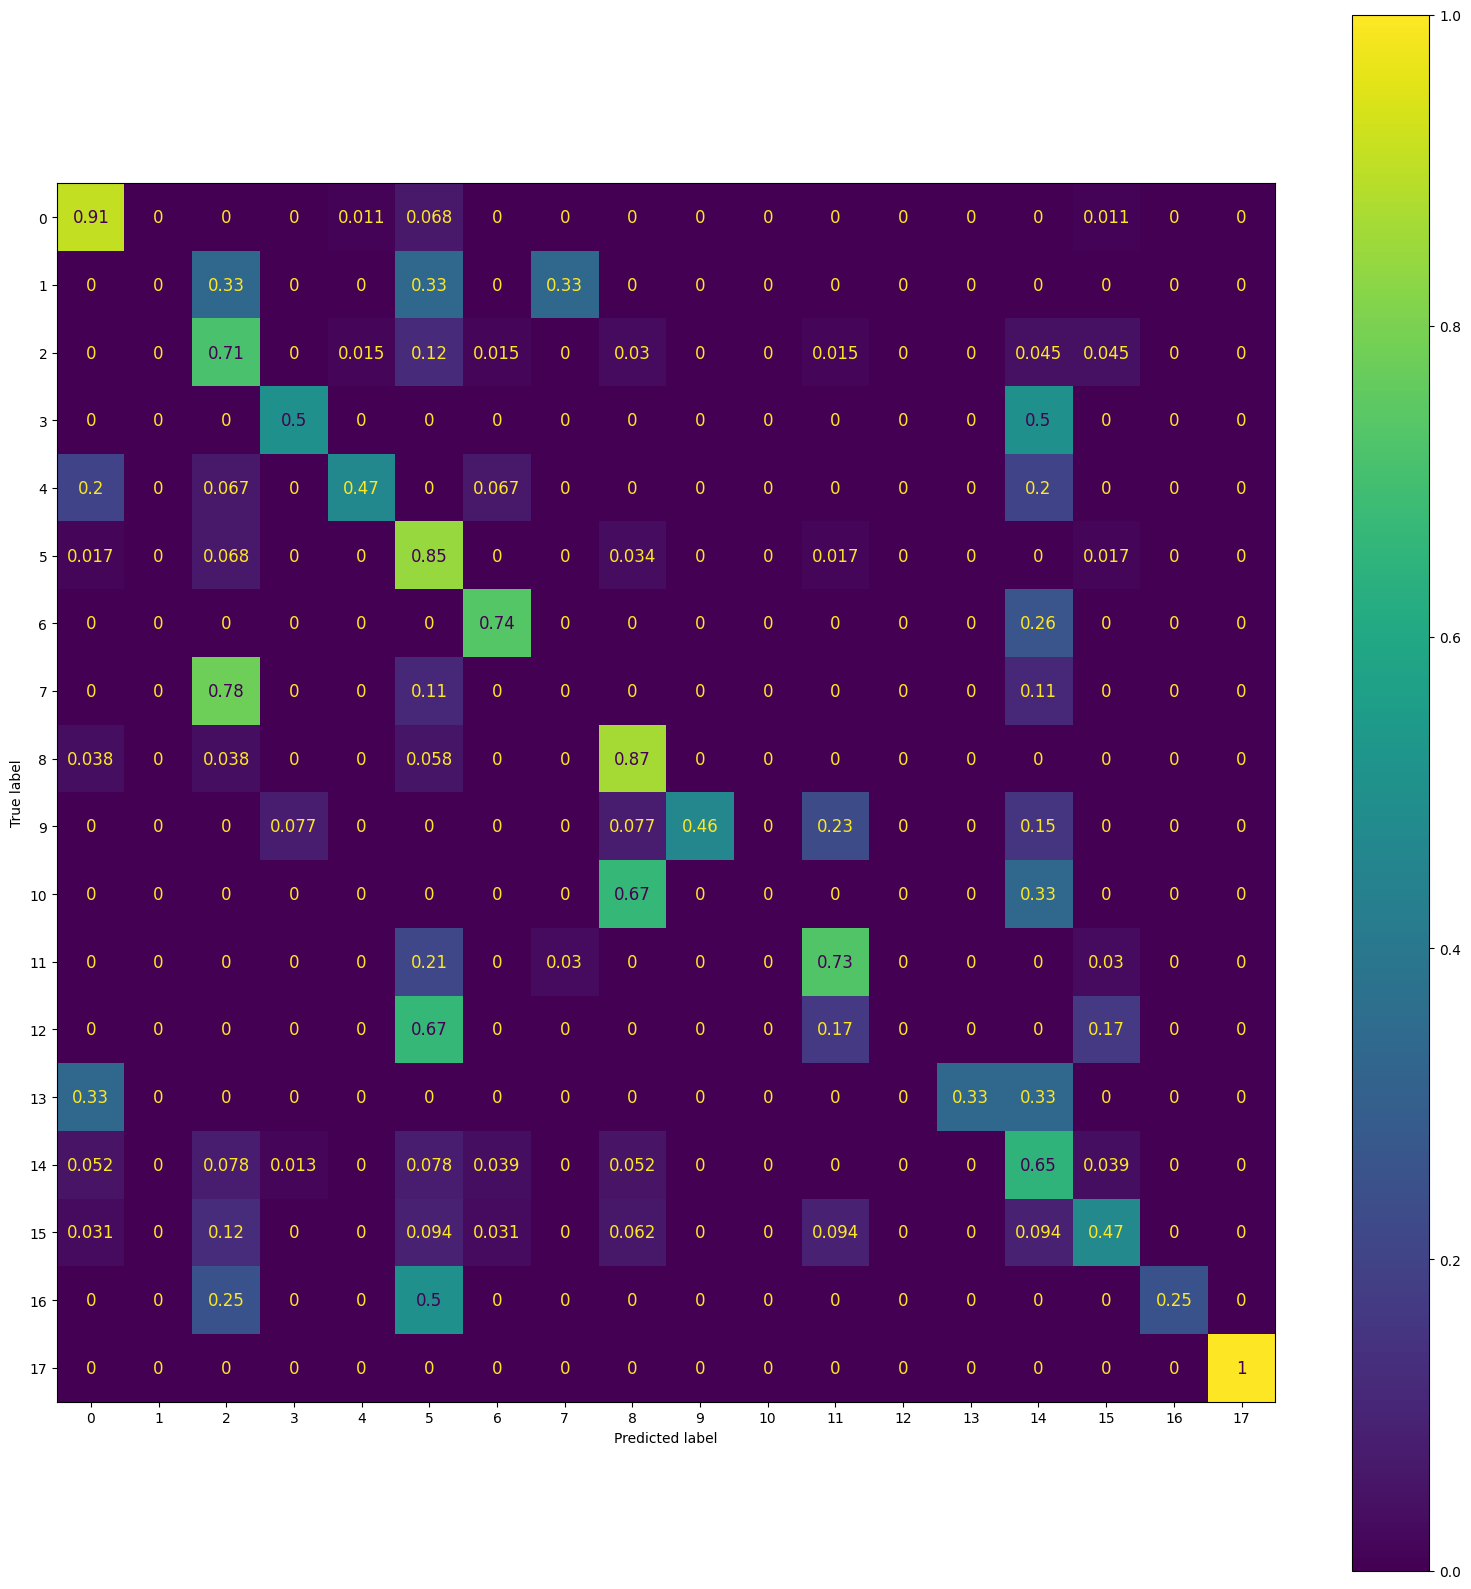

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(16, 16), squeeze=False)
cm = confusion_matrix(y_val, y_pred_val, labels=list(range(18)))
cm = cm / np.sum(cm, axis=1)[:, None]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(18)))
disp.plot(ax=axs[0, 0], text_kw={"fontsize": 12})
plt.tight_layout()
plt.savefig("confusion_matrix.png")
